In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = 'LogiReg_data.txt'
pdData = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
pdData.shape

(100, 3)

Text(0,0.5,'Exam 2 Score')

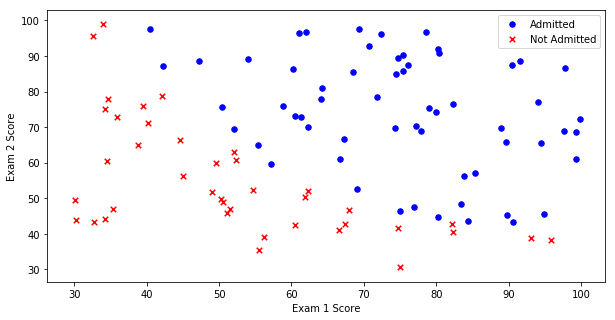

In [4]:
positive = pdData[pdData['Admitted']==1]# 录取学生
negative = pdData[pdData['Admitted']==0]# 未录取学生

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()# 显示标签
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

In [5]:
# 由值到概率的映射sigmoid函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
# 预测函数
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))

In [7]:
pdData.insert(0, 'Ones', 1)# 新加一列，值为1，名为‘Ones’
orig_data = pdData.as_matrix()# 从dataframe转换为矩阵
cols = orig_data.shape[1]# 取出列数
X = orig_data[:, 0:cols-1]# 变量x
y = orig_data[:, cols-1:cols]# 结果y
theta = np.zeros([1, 3])# 构造三个theta参数，用0占位

In [8]:
X[:5]

array([[  1.        ,  34.62365962,  78.02469282],
       [  1.        ,  30.28671077,  43.89499752],
       [  1.        ,  35.84740877,  72.90219803],
       [  1.        ,  60.18259939,  86.3085521 ],
       [  1.        ,  79.03273605,  75.34437644]])

In [9]:
y[:5]

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.]])

In [10]:
theta

array([[ 0.,  0.,  0.]])

In [11]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

In [12]:
# 损失函数（似然函数）
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1-y, np.log(1 - model(X, theta)))
    return np.sum(left-right)/(len(X))

In [13]:
cost(X, y, theta)

0.69314718055994529

In [14]:
# 计算梯度
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta)-y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term)/len(X)
        
    return grad

In [15]:
# 比较三种不同梯度下降方法
STOP_ITER = 0# 根据迭代次数判断停止策略
STOP_COST = 1# 根据损失变化判断停止策略
STOP_GRAD = 2# 根据梯度判断停止策略

def stopCriterion(type, value, threshold):
    # 设置三种不同的停止策略
    if type ==STOP_ITER:
        return value > threshold
    elif type == STOP_COST:
        return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:
        return np.linalg.norm(value) < threshold

In [16]:
import numpy.random
# 洗牌，把数据打乱
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

In [33]:
import time
def descent(data, theta, batchSize, stopType, thresh, alpha):
    # 梯度下降求解
    
    init_time = time.time()
    i = 0# 迭代此时
    k = 0# batch
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape)# 计算的梯度
    costs = [cost(X, y, theta)]# 损失值
    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #batch数量个数据
        if k >= n:
            k = 0
            X, y = shuffleData(data)# 重新洗牌
        theta = theta - alpha * grad# 参数更新
        costs.append(cost(X, y, theta))# 计算新的损失
        i += 1
        
        if stopType ==STOP_ITER:
            value = i
        elif stopType == STOP_COST:
            value = costs
        elif stopType == STOP_GRAD:
            value = grad
        if stopCriterion(stopType, value, thresh):
            break
            
    return theta, i-1, costs, grad, time.time() - init_time

In [25]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.92s


array([[-0.00027127,  0.00705232,  0.00376711]])

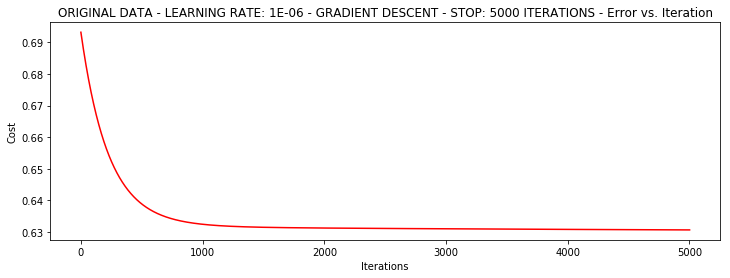

In [34]:
# 选择的梯度下降方法是基于所有样本的
n = 100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 20.04s


array([[-5.13364014,  0.04771429,  0.04072397]])

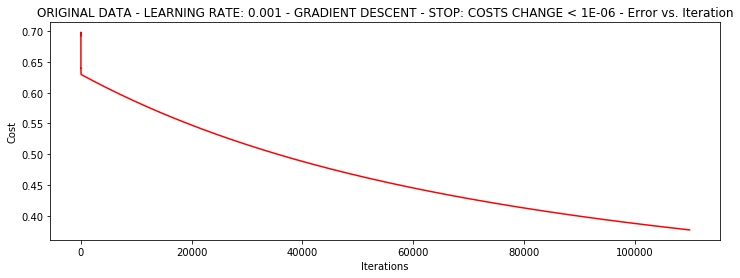

In [35]:
# 根据损失值停止
# 设定阈值1E-6，差不多需要110000次迭代
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 7.71s


array([[-2.37033409,  0.02721692,  0.01899456]])

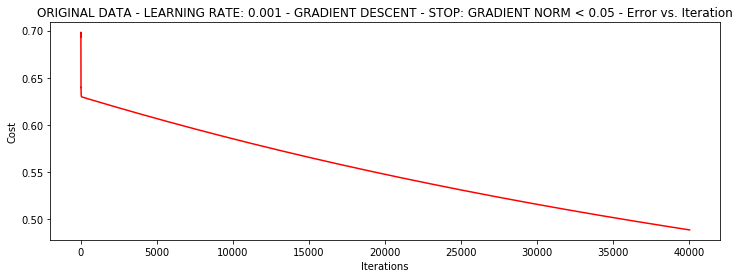

In [38]:
# 根据梯度变化停止
# 设置阈值0.05，差不多需要40000次迭代
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.39025756  0.07255207 -0.08406542]] - Iter: 5000 - Last cost: 1.33 - Duration: 0.26s


array([[-0.39025756,  0.07255207, -0.08406542]])

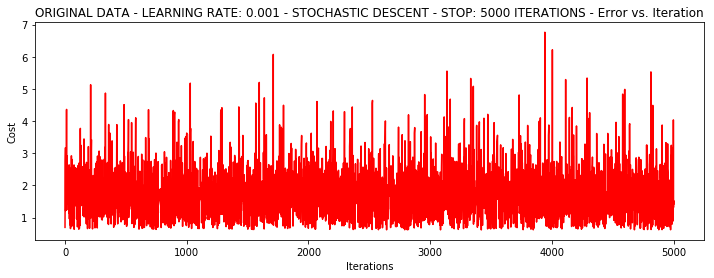

In [39]:
# 每次只迭代一个样本
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.00202226  0.00996093  0.0008834 ]] - Iter: 15000 - Last cost: 0.63 - Duration: 0.77s


array([[-0.00202226,  0.00996093,  0.0008834 ]])

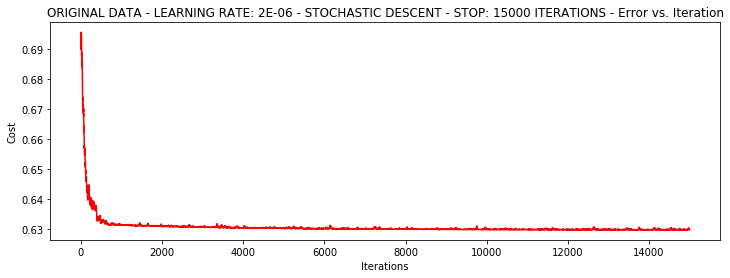

In [41]:
# 把学习率调小一些
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[ -1.03428751e+00   1.68818575e-02  -4.70052692e-04]] - Iter: 15000 - Last cost: 0.61 - Duration: 1.11s


array([[ -1.03428751e+00,   1.68818575e-02,  -4.70052692e-04]])

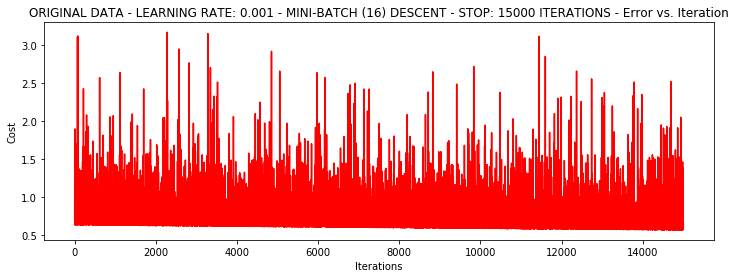

In [42]:
# Mini-batch descent
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[ 0.3080807   0.86494967  0.77367651]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.96s


array([[ 0.3080807 ,  0.86494967,  0.77367651]])

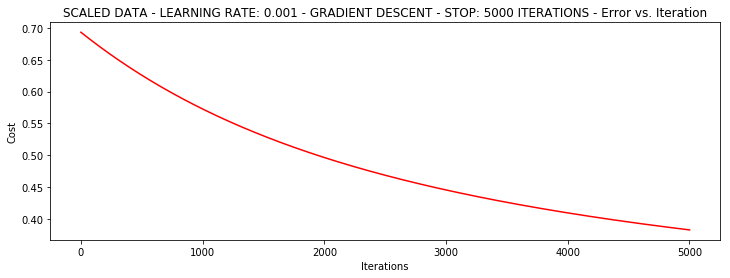

In [43]:
# 数据标准化
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])
runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

In [44]:
# 设定阈值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [45]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a==1 and b ==1) or (a==0 and b==0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct))%len(correct))
print('accuracy = {0}%'.format(accuracy))

accuracy = 60%
